In [ ]:
! nvidia-smi

Tue Apr 12 01:50:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os,sys
import os.path
import numpy as np
import torch

from sklearn.utils import shuffle

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import random
import pdb
import argparse,time
import math
from copy import deepcopy

In [ ]:
cf100_dir = '/content/drive/MyDrive/CSN-300 Lab based project Advanced/Gradient Projection Memory for continual learning/data'
file_dir = '/content/drive/MyDrive/CSN-300 Lab based project Advanced/Gradient Projection Memory for continual learning/data/binary_cifar100'

In [ ]:
def get(seed=0,pc_valid=0.10):
    data={}
    taskcla=[]
    size=[3,32,32]

    if not os.path.isdir(file_dir):
        os.makedirs(file_dir)

        mean=[x/255 for x in [125.3,123.0,113.9]]
        std=[x/255 for x in [63.0,62.1,66.7]]

        # CIFAR100
        dat={}
        dat['train']=datasets.CIFAR100(cf100_dir,train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        dat['test']=datasets.CIFAR100(cf100_dir,train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        # dat['train'] = datasets.CIFAR100(cf100_dir,train=True,download=False,transform=transforms.Compose([transforms.ToTensor()]))
        # dat['test']  = datasets.CIFAR100(cf100_dir,train=False,download=False,transform=transforms.Compose([transforms.ToTensor()]))
        for n in range(10):
            data[n]={}
            data[n]['name']='cifar100'
            data[n]['ncla']=10
            data[n]['train']={'x': [],'y': []}
            data[n]['test']={'x': [],'y': []}
        for s in ['train','test']:
            loader=torch.utils.data.DataLoader(dat[s],batch_size=1,shuffle=False)
            for image,target in loader:
                n=target.numpy()[0]
                nn=(n//10)
                data[nn][s]['x'].append(image) # 255 
                data[nn][s]['y'].append(n%10)

        # "Unify" and save
        for t in data.keys():
            for s in ['train','test']:
                data[t][s]['x']=torch.stack(data[t][s]['x']).view(-1,size[0],size[1],size[2])
                data[t][s]['y']=torch.LongTensor(np.array(data[t][s]['y'],dtype=int)).view(-1)
                torch.save(data[t][s]['x'], os.path.join(os.path.expanduser(file_dir),'data'+str(t)+s+'x.bin'))
                torch.save(data[t][s]['y'], os.path.join(os.path.expanduser(file_dir),'data'+str(t)+s+'y.bin'))

    # Load binary files
    data={}
    # ids=list(shuffle(np.arange(5),random_state=seed))
    ids=list(np.arange(10))
    print('Task order =',ids)
    for i in range(10):
        data[i] = dict.fromkeys(['name','ncla','train','test'])
        for s in ['train','test']:
            data[i][s]={'x':[],'y':[]}
            data[i][s]['x']=torch.load(os.path.join(os.path.expanduser(file_dir),'data'+str(ids[i])+s+'x.bin'))
            data[i][s]['y']=torch.load(os.path.join(os.path.expanduser(file_dir),'data'+str(ids[i])+s+'y.bin'))
        data[i]['ncla']=len(np.unique(data[i]['train']['y'].numpy()))
        if data[i]['ncla']==2:
            data[i]['name']='cifar10-'+str(ids[i])
        else:
            data[i]['name']='cifar100-'+str(ids[i])

    # Validation
    for t in data.keys():
        r=np.arange(data[t]['train']['x'].size(0))
        r=np.array(shuffle(r,random_state=seed),dtype=int)
        nvalid=int(pc_valid*len(r))
        ivalid=torch.LongTensor(r[:nvalid])
        itrain=torch.LongTensor(r[nvalid:])
        data[t]['valid']={}
        data[t]['valid']['x']=data[t]['train']['x'][ivalid].clone()
        data[t]['valid']['y']=data[t]['train']['y'][ivalid].clone()
        data[t]['train']['x']=data[t]['train']['x'][itrain].clone()
        data[t]['train']['y']=data[t]['train']['y'][itrain].clone()

    # Others
    n=0
    for t in data.keys():
        taskcla.append((t,data[t]['ncla']))
        n+=data[t]['ncla']
    data['ncla']=n

    return data,taskcla,size

In [ ]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [ ]:
class AlexNet(nn.Module):
    def __init__(self,taskcla):
        super(AlexNet, self).__init__()
        self.act=OrderedDict()
        self.map =[]
        self.ksize=[]
        self.in_channel =[]
        self.map.append(32)
        self.conv1 = nn.Conv2d(3, 64, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=False)
        s=compute_conv_output_size(32,4)
        s=s//2
        self.ksize.append(4)
        self.in_channel.append(3)
        self.map.append(s)
        self.conv2 = nn.Conv2d(64, 128, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(128, track_running_stats=False)
        s=compute_conv_output_size(s,3)
        s=s//2
        self.ksize.append(3)
        self.in_channel.append(64)
        self.map.append(s)
        self.conv3 = nn.Conv2d(128, 256, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(256, track_running_stats=False)
        s=compute_conv_output_size(s,2)
        s=s//2
        self.smid=s
        self.ksize.append(2)
        self.in_channel.append(128)
        self.map.append(256*self.smid*self.smid)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.relu=torch.nn.ReLU()
        self.drop1=torch.nn.Dropout(0.2)
        self.drop2=torch.nn.Dropout(0.5)

        self.fc1 = nn.Linear(256*self.smid*self.smid,2048, bias=False)
        self.bn4 = nn.BatchNorm1d(2048, track_running_stats=False)
        self.fc2 = nn.Linear(2048,2048, bias=False)
        self.bn5 = nn.BatchNorm1d(2048, track_running_stats=False)
        self.map.extend([2048])
        
        self.taskcla = taskcla
        self.fc3=torch.nn.ModuleList()
        for t,n in self.taskcla:
            self.fc3.append(torch.nn.Linear(2048,n,bias=False))
        
    def forward(self, x):
        bsz = deepcopy(x.size(0))
        self.act['conv1']=x
        x = self.conv1(x)
        x = self.maxpool(self.drop1(self.relu(self.bn1(x))))

        self.act['conv2']=x
        x = self.conv2(x)
        x = self.maxpool(self.drop1(self.relu(self.bn2(x))))

        self.act['conv3']=x
        x = self.conv3(x)
        x = self.maxpool(self.drop2(self.relu(self.bn3(x))))

        x=x.view(bsz,-1)
        self.act['fc1']=x
        x = self.fc1(x)
        x = self.drop2(self.relu(self.bn4(x)))

        self.act['fc2']=x        
        x = self.fc2(x)
        x = self.drop2(self.relu(self.bn5(x)))
        y=[]
        for t,i in self.taskcla:
            y.append(self.fc3[t](x))
            
        return y

In [ ]:
def get_model(model):
    return deepcopy(model.state_dict())

In [ ]:
def set_model_(model,state_dict):
    model.load_state_dict(deepcopy(state_dict))
    return

In [ ]:
def adjust_learning_rate(optimizer, epoch, args):
    for param_group in optimizer.param_groups:
        if (epoch ==1):
            param_group['lr']=args.lr
        else:
            param_group['lr'] /= args.lr_factor

In [ ]:
def train(args, model, device, x,y, optimizer,criterion, task_id):
    model.train()
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    # Loop batches
    for i in range(0,len(r),args.batch_size_train):
        if i+args.batch_size_train<=len(r): b=r[i:i+args.batch_size_train]
        else: b=r[i:]
        data = x[b]
        data, target = data.to(device), y[b].to(device)
        optimizer.zero_grad()        
        output = model(data)
        loss = criterion(output[task_id], target)        
        loss.backward()
        optimizer.step()

In [ ]:
def train_projected(args,model,device,x,y,optimizer,criterion,feature_mat,task_id):
    model.train()
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    # Loop batches
    for i in range(0,len(r),args.batch_size_train):
        if i+args.batch_size_train<=len(r): b=r[i:i+args.batch_size_train]
        else: b=r[i:]
        data = x[b]
        data, target = data.to(device), y[b].to(device)
        optimizer.zero_grad()        
        output = model(data)
        loss = criterion(output[task_id], target)         
        loss.backward()
        # Gradient Projections 
        kk = 0 
        for k, (m,params) in enumerate(model.named_parameters()):
            if k<15 and len(params.size())!=1:
                sz =  params.grad.data.size(0)
                params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                                        feature_mat[kk]).view(params.size())
                kk +=1
            elif (k<15 and len(params.size())==1) and task_id !=0 :
                params.grad.data.fill_(0)

        optimizer.step()

In [ ]:
def test(args, model, device, x, y, criterion, task_id):
    model.eval()
    total_loss = 0
    total_num = 0 
    correct = 0
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    with torch.no_grad():
        # Loop batches
        for i in range(0,len(r),args.batch_size_test):
            if i+args.batch_size_test<=len(r): b=r[i:i+args.batch_size_test]
            else: b=r[i:]
            data = x[b]
            data, target = data.to(device), y[b].to(device)
            output = model(data)
            loss = criterion(output[task_id], target)
            pred = output[task_id].argmax(dim=1, keepdim=True) 
            
            correct    += pred.eq(target.view_as(pred)).sum().item()
            total_loss += loss.data.cpu().numpy().item()*len(b)
            total_num  += len(b)

    acc = 100. * correct / total_num
    final_loss = total_loss / total_num
    return final_loss, acc

In [ ]:
def get_representation_matrix (net, device, x, y=None): 
    # Collect activations by forward pass
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    b=r[0:125] # Take 125 random samples 
    example_data = x[b]
    example_data = example_data.to(device)
    example_out  = net(example_data)
    
    batch_list=[2*12,100,100,125,125] 
    mat_list=[]
    act_key=list(net.act.keys())
    for i in range(len(net.map)):
        bsz=batch_list[i]
        k=0
        if i<3:
            ksz= net.ksize[i]
            s=compute_conv_output_size(net.map[i],net.ksize[i])
            mat = np.zeros((net.ksize[i]*net.ksize[i]*net.in_channel[i],s*s*bsz))
            act = net.act[act_key[i]].detach().cpu().numpy()
            for kk in range(bsz):
                for ii in range(s):
                    for jj in range(s):
                        mat[:,k]=act[kk,:,ii:ksz+ii,jj:ksz+jj].reshape(-1) 
                        k +=1
            mat_list.append(mat)
        else:
            act = net.act[act_key[i]].detach().cpu().numpy()
            activation = act[0:bsz].transpose()
            mat_list.append(activation)

    print('-'*30)
    print('Representation Matrix')
    print('-'*30)
    for i in range(len(mat_list)):
        print ('Layer {} : {}'.format(i+1,mat_list[i].shape))
    print('-'*30)
    return mat_list

In [ ]:
def update_GPM (model, mat_list, threshold, feature_list=[],):
    print ('Threshold: ', threshold) 
    if not feature_list:
        # After First Task 
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U,S,Vh = np.linalg.svd(activation, full_matrices=False)
            # criteria (Eq-5)
            sval_total = (S**2).sum()
            sval_ratio = (S**2)/sval_total
            r = np.sum(np.cumsum(sval_ratio)<threshold[i]) #+1  
            feature_list.append(U[:,0:r])
    else:
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U1,S1,Vh1=np.linalg.svd(activation, full_matrices=False)
            sval_total = (S1**2).sum()
            # Projected Representation (Eq-8)
            act_hat = activation - np.dot(np.dot(feature_list[i],feature_list[i].transpose()),activation)
            U,S,Vh = np.linalg.svd(act_hat, full_matrices=False)
            # criteria (Eq-9)
            sval_hat = (S**2).sum()
            sval_ratio = (S**2)/sval_total               
            accumulated_sval = (sval_total-sval_hat)/sval_total
            
            r = 0
            for ii in range (sval_ratio.shape[0]):
                if accumulated_sval < threshold[i]:
                    accumulated_sval += sval_ratio[ii]
                    r += 1
                else:
                    break
            if r == 0:
                print ('Skip Updating GPM for layer: {}'.format(i+1)) 
                continue
            # update GPM
            Ui=np.hstack((feature_list[i],U[:,0:r]))  
            if Ui.shape[1] > Ui.shape[0] :
                feature_list[i]=Ui[:,0:Ui.shape[0]]
            else:
                feature_list[i]=Ui
    
    print('-'*40)
    print('Gradient Constraints Summary')
    print('-'*40)
    for i in range(len(feature_list)):
        print ('Layer {} : {}/{}'.format(i+1,feature_list[i].shape[1], feature_list[i].shape[0]))
    print('-'*40)
    return feature_list 

In [ ]:
def main(args):
    tstart=time.time()
    ## Device Setting 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    ## Load CIFAR100 DATASET
    data,taskcla,inputsize=get(seed=args.seed, pc_valid=args.pc_valid)

    acc_matrix=np.zeros((10,10))
    criterion = torch.nn.CrossEntropyLoss()

    task_id = 0
    task_list = []
    for k,ncla in taskcla:
        # specify threshold hyperparameter
        threshold = np.array([0.97] * 5) + task_id*np.array([0.003] * 5)
     
        print('*'*100)
        print('Task {:2d} ({:s})'.format(k,data[k]['name']))
        print('*'*100)
        xtrain=data[k]['train']['x']
        ytrain=data[k]['train']['y']
        xvalid=data[k]['valid']['x']
        yvalid=data[k]['valid']['y']
        xtest =data[k]['test']['x']
        ytest =data[k]['test']['y']
        task_list.append(k)

        lr = args.lr 
        best_loss=np.inf
        print ('-'*40)
        print ('Task ID :{} | Learning Rate : {}'.format(task_id, lr))
        print ('-'*40)
        
        if task_id==0:
            model = AlexNet(taskcla).to(device)
            print ('Model parameters ---')
            for k_t, (m, param) in enumerate(model.named_parameters()):
                print (k_t,m,param.shape)
            print ('-'*40)

            best_model=get_model(model)
            feature_list =[]
            optimizer = optim.SGD(model.parameters(), lr=lr)

            for epoch in range(1, args.n_epochs+1):
                # Train
                clock0=time.time()
                train(args, model, device, xtrain, ytrain, optimizer, criterion, k)
                clock1=time.time()
                tr_loss,tr_acc = test(args, model, device, xtrain, ytrain,  criterion, k)
                print('Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% | time={:5.1f}ms |'.format(epoch,\
                                                            tr_loss,tr_acc, 1000*(clock1-clock0)),end='')
                # Validate
                valid_loss,valid_acc = test(args, model, device, xvalid, yvalid,  criterion, k)
                print(' Valid: loss={:.3f}, acc={:5.1f}% |'.format(valid_loss, valid_acc),end='')
                # Adapt lr
                if valid_loss<best_loss:
                    best_loss=valid_loss
                    best_model=get_model(model)
                    patience=args.lr_patience
                    print(' *',end='')
                else:
                    patience-=1
                    if patience<=0:
                        lr/=args.lr_factor
                        print(' lr={:.1e}'.format(lr),end='')
                        if lr<args.lr_min:
                            print()
                            break
                        patience=args.lr_patience
                        adjust_learning_rate(optimizer, epoch, args)
                print()
            set_model_(model,best_model)
            # Test
            print ('-'*40)
            test_loss, test_acc = test(args, model, device, xtest, ytest,  criterion, k)
            print('Test: loss={:.3f} , acc={:5.1f}%'.format(test_loss,test_acc))
            # Memory Update  
            mat_list = get_representation_matrix (model, device, xtrain, ytrain)
            feature_list = update_GPM (model, mat_list, threshold, feature_list)

        else:
            optimizer = optim.SGD(model.parameters(), lr=args.lr)
            feature_mat = []
            # Projection Matrix Precomputation
            for i in range(len(model.act)):
                Uf=torch.Tensor(np.dot(feature_list[i],feature_list[i].transpose())).to(device)
                print('Layer {} - Projection Matrix shape: {}'.format(i+1,Uf.shape))
                feature_mat.append(Uf)
            print ('-'*40)
            for epoch in range(1, args.n_epochs+1):
                # Train 
                clock0=time.time()
                train_projected(args, model,device,xtrain, ytrain,optimizer,criterion,feature_mat,k)
                clock1=time.time()
                tr_loss, tr_acc = test(args, model, device, xtrain, ytrain,criterion,k)
                print('Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% | time={:5.1f}ms |'.format(epoch,\
                                                        tr_loss, tr_acc, 1000*(clock1-clock0)),end='')
                # Validate
                valid_loss,valid_acc = test(args, model, device, xvalid, yvalid, criterion,k)
                print(' Valid: loss={:.3f}, acc={:5.1f}% |'.format(valid_loss, valid_acc),end='')
                # Adapt lr
                if valid_loss<best_loss:
                    best_loss=valid_loss
                    best_model=get_model(model)
                    patience=args.lr_patience
                    print(' *',end='')
                else:
                    patience-=1
                    if patience<=0:
                        lr/=args.lr_factor
                        print(' lr={:.1e}'.format(lr),end='')
                        if lr<args.lr_min:
                            print()
                            break
                        patience=args.lr_patience
                        adjust_learning_rate(optimizer, epoch, args)
                print()
            set_model_(model,best_model)
            # Test 
            test_loss, test_acc = test(args, model, device, xtest, ytest,  criterion,k)
            print('Test: loss={:.3f} , acc={:5.1f}%'.format(test_loss,test_acc))  
            # Memory Update 
            mat_list = get_representation_matrix (model, device, xtrain, ytrain)
            feature_list = update_GPM (model, mat_list, threshold, feature_list)
        
        # save accuracy 
        jj = 0 
        for ii in np.array(task_list)[0:task_id+1]:
            xtest =data[ii]['test']['x']
            ytest =data[ii]['test']['y'] 
            _, acc_matrix[task_id,jj] = test(args, model, device, xtest, ytest,criterion,ii) 
            jj +=1
        print('Accuracies =')
        for i_a in range(task_id+1):
            print('\t',end='')
            for j_a in range(acc_matrix.shape[1]):
                print('{:5.1f}% '.format(acc_matrix[i_a,j_a]),end='')
            print()
        # update task id 
        task_id +=1
    print('-'*50)
    # Simulation Results 
    print ('Task Order : {}'.format(np.array(task_list)))
    print ('Final Avg Accuracy: {:5.2f}%'.format(acc_matrix[-1].mean())) 
    bwt=np.mean((acc_matrix[-1]-np.diag(acc_matrix))[:-1]) 
    print ('Backward transfer: {:5.2f}%'.format(bwt))
    print('[Elapsed time = {:.1f} ms]'.format((time.time()-tstart)*1000))
    print('-'*50)
    # Plots
    array = acc_matrix
    df_cm = pd.DataFrame(array, index = [i for i in ["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10"]],
                      columns = [i for i in ["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10"]])
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10})
    plt.show()


Arguments =
	batch_size_train: 64
	batch_size_test: 64
	n_epochs: 200
	seed: 1
	pc_valid: 0.05
	lr: 0.01
	momentum: 0.9
	lr_min: 1e-05
	lr_patience: 6
	lr_factor: 2


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CSN-300 Lab based project Advanced/Gradient Projection Memory for continual learning/data/cifar-100-python.tar.gz to /content/drive/MyDrive/CSN-300 Lab based project Advanced/Gradient Projection Memory for continual learning/data
Files already downloaded and verified
Task order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
****************************************************************************************************
Task  0 (cifar100-0)
****************************************************************************************************
----------------------------------------
Task ID :0 | Learning Rate : 0.01
----------------------------------------
Model parameters ---
0 conv1.weight torch.Size([64, 3, 4, 4])
1 bn1.weight torch.Size([64])
2 bn1.bias torch.Size([64])
3 conv2.weight torch.Size([128, 64, 3, 3])
4 bn2.weight torch.Size([128])
5 bn2.bias torch.Size([128])
6 conv3.weight torch.Size([256, 128, 2, 2])
7 bn3.weight torch.Size([256])
8 bn3.bias torch.

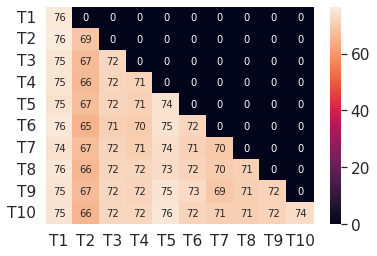

In [ ]:
if __name__ == "__main__":
    # Training parameters
    parser = argparse.ArgumentParser(description='Sequential PMNIST with GPM')
    parser.add_argument('--batch_size_train', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--batch_size_test', type=int, default=64, metavar='N',
                        help='input batch size for testing (default: 64)')
    parser.add_argument('--n_epochs', type=int, default=200, metavar='N',
                        help='number of training epochs/task (default: 200)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--pc_valid',default=0.05,type=float,
                        help='fraction of training data used for validation')
    # Optimizer parameters
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--lr_min', type=float, default=1e-5, metavar='LRM',
                        help='minimum lr rate (default: 1e-5)')
    parser.add_argument('--lr_patience', type=int, default=6, metavar='LRP',
                        help='hold before decaying lr (default: 6)')
    parser.add_argument('--lr_factor', type=int, default=2, metavar='LRF',
                        help='lr decay factor (default: 2)')

    args, unknown = parser.parse_known_args()
    print('='*100)
    print('Arguments =')
    for arg in vars(args):
        print('\t'+arg+':',getattr(args,arg))
    print('='*100)

    main(args)